<a href="https://colab.research.google.com/github/shihmujan/classs/blob/main/shap_cat_and_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gdown
import zipfile 
import os 

def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    zf.extractall()

url = 'https://drive.google.com/u/1/uc?id=1hsXJZKCxLobxJybHsM8pw-b9GaFj8NTc&export=download&confirm=t'
output = "cat_dog.zip"
gdown.download(url, output)

file_path = "cat_dog.zip"
zip_list(file_path)

Downloading...
From: https://drive.google.com/u/1/uc?id=1hsXJZKCxLobxJybHsM8pw-b9GaFj8NTc&export=download&confirm=t
To: /content/cat_dog.zip
100%|██████████| 249M/249M [00:05<00:00, 49.6MB/s]


In [2]:
!pip install shap
!pip install lime
!pip install efficientnet_pytorch
!pip uninstall imgaug
!pip uninstall matplotlib
!pip install matplotlib==3.5.1

     |████████████████████████████████| 564 kB 5.0 MB/s 
     |████████████████████████████████| 275 kB 5.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=2b2057cf1369a6af93846feb501fb1450a909b3348cb39cf2aa349edd409d8cb
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=1b8a7cf0ecfc2b1dbeba2e380f377eb936c43bcf94f15de38d8b0ec2abbcc00a
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/imgaug-0.2.9.dist-info/*
    /usr/local/lib/python3.7/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.2.9
Found existing inst

In [1]:
import os
import warnings
import numpy as np
warnings.filterwarnings('ignore')
from trainer import trainer
import shap
from Confusion_Matrix import show_confusion_matrix
from loss_fn import *
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from transform import *
import torch.nn as nn
from utils_tool import *
import torch.optim as optim
from Show_Image import Show_Many_Image, Lime_Init

In [2]:
lr = 0.0005  #學習率
resume = True  #是否使用預訓練資料
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_worker = 4
epoch = 500
batch_size = 50
momentum = 0.9
train_path = 'cat_and_dog/train/'
test_path = 'cat_and_dog/test/'


In [4]:
train_ds, test_ds, idx_to_class = get_dataloader(train_path, test_path, batch_size, num_worker)
class_to_id = {v: k for k, v in idx_to_class.items()}
class_names = ['cat', 'dog']
print(idx_to_class)
model = EfficientNet.from_pretrained('efficientnet-b2').to(device)
num_feature = model._fc.in_features
model._fc = nn.Linear(num_feature, 2).to(device)
model.fc = nn.Linear(num_feature, 2).to(device)

if resume:
    print('==> Resuming from checkpoint..')
    checkpoint = torch.load('checkpoint/ckpt_0.pth')
    model.load_state_dict(checkpoint['net'])

optimizer = torch.optim.Adam(params=model.parameters(),lr=lr,betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
criterion = nn.CrossEntropyLoss()

train = trainer(train_ds,test_ds, model, optimizer, scheduler, criterion, epoch)
train.vaild_scaler_epoch(0)

{0: 'cat', 1: 'dog'}
Loaded pretrained weights for efficientnet-b2
==> Resuming from checkpoint..


Epoch 1: 100%|██████████| 60/60 [00:10<00:00,  5.67it/s, Acc=0.995, loss=0.0148]


Epoch : 1, Val_loss : 0.01411756407469511, Acc : 0.995


100%|██████████| 60/60 [00:10<00:00,  5.49it/s]


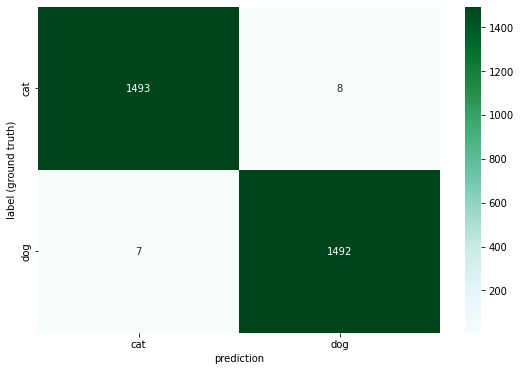

In [5]:
transfer = get_test_transforms()
y_pred, y_true, cofusion_dict = save_image_path_lab_pred(model, test_path, class_to_id, transfer, batch_size, num_worker)
show_confusion_matrix(test_ds, model, class_names, y_pred, y_true)

  0%|          | 0/300 [00:00<?, ?it/s]

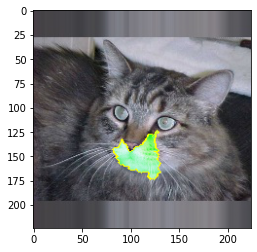

In [7]:
image_visable = Show_Many_Image(model, cofusion_dict, (224, 224, 3), class_to_id)
image, class_name, pred_name = image_visable.get_image('cat', 'cat')
explain = Lime_Init(model, get_test_transforms())
exp = explain.lime_default(image, top_label=1, num_samples=300)
img = explain.lime_explain(exp, label=0)
plt.imshow(img)

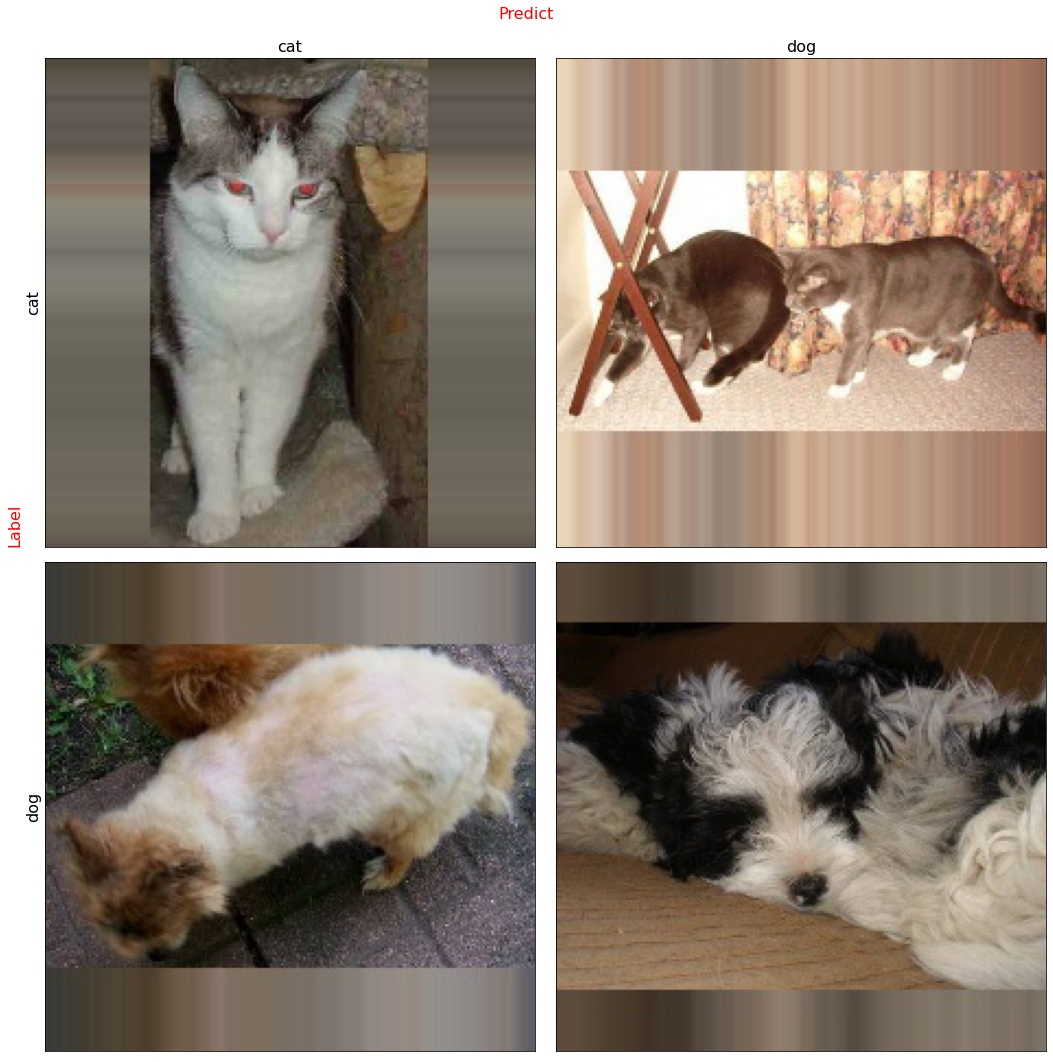

In [8]:
image_visable = Show_Many_Image(model, cofusion_dict, (224, 224, 3), class_to_id)
image_list = image_visable.get_image_matrix(row=2,col=2)
image_visable.show_image(image_list,title=True, row=2, col=2)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

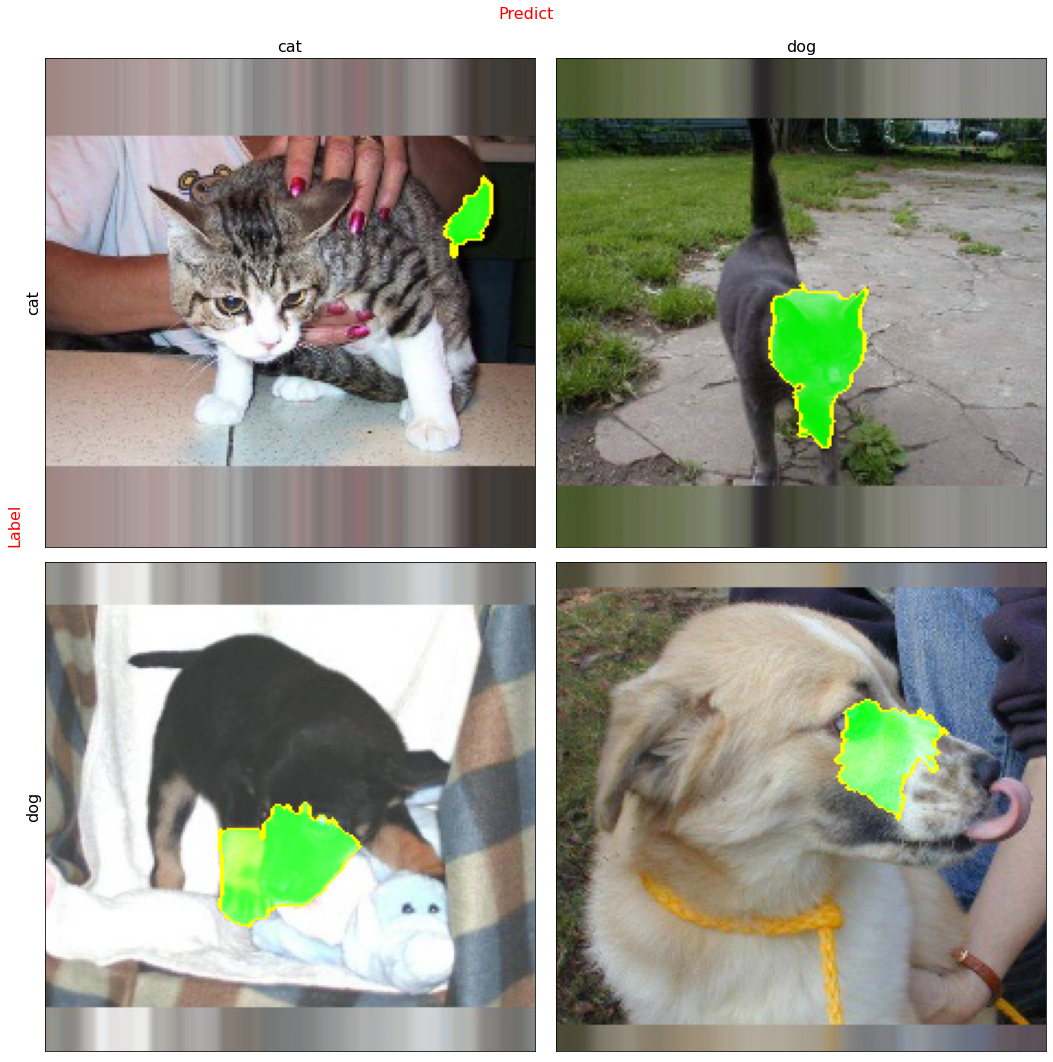

In [10]:
# 解釋類別標籤最大區域
image_list = image_visable.get_image_matrix(row=2, col=2)
explain = Lime_Init(model, get_test_transforms())
for i in range(len(image_list)):
    data = image_list[i]
    exp = explain.lime_default(np.array(data[0]), top_label=3)
    img = explain.lime_explain(exp, data[1])
    image_list[i][0] = img
image_visable.show_image(image_list, row=2, col=2)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

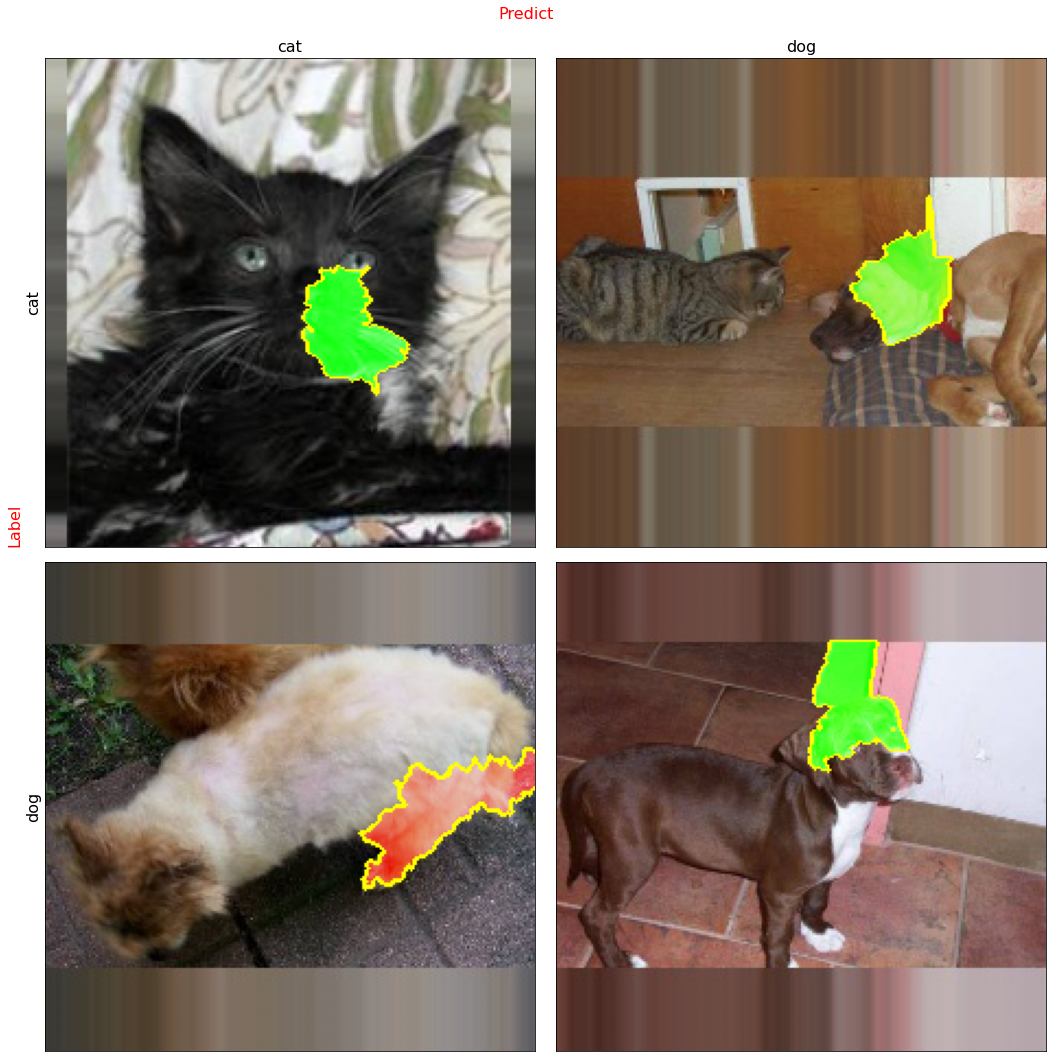

In [12]:
# 解釋預測標籤最大區域
image_list = image_visable.get_image_matrix(row=2, col=2)
explain = Lime_Init(model, get_test_transforms())
for i in range(len(image_list)):
    data = image_list[i]
    exp = explain.lime_default(np.array(data[0]), top_label=3)
    img = explain.lime_explain(exp, data[2])
    image_list[i][0] = img
image_visable.show_image(image_list, row=2, col=2)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

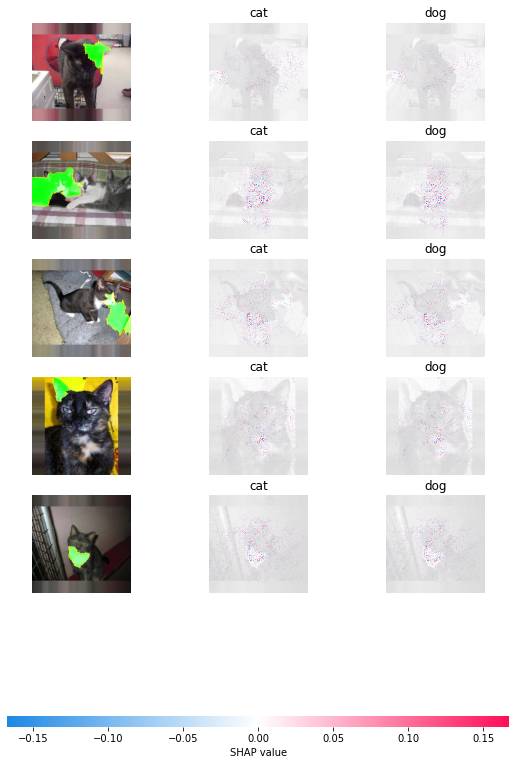

In [13]:
import warnings
warnings.filterwarnings('ignore')

image_list = []
index_lab = []
index_pred = []
explain_list = []

for i in range(5):
  image, lab_name, pred_name = image_visable.get_image(idx_to_class[0], idx_to_class[0])

  exp = explain.lime_default(image, top_label=3)
  explain_list.append(explain.lime_explain(exp, 0))
  image_list.append(transfer(Image.fromarray(image)))
  index_lab.append(lab_name)
  index_pred.append(pred_name)

explain_list = np.stack(explain_list)
image_list = torch.stack(image_list)
index_lab = np.array([np.array(class_names),np.array(class_names),np.array(class_names),np.array(class_names),np.array(class_names)])
index_pred = np.array(index_pred)


background = image_list.to(device)
e = shap.DeepExplainer(model, background)
n_test_images = 5
shap_values = e.shap_values(background)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]


shap.image_plot(shap_numpy, explain_list, index_lab)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

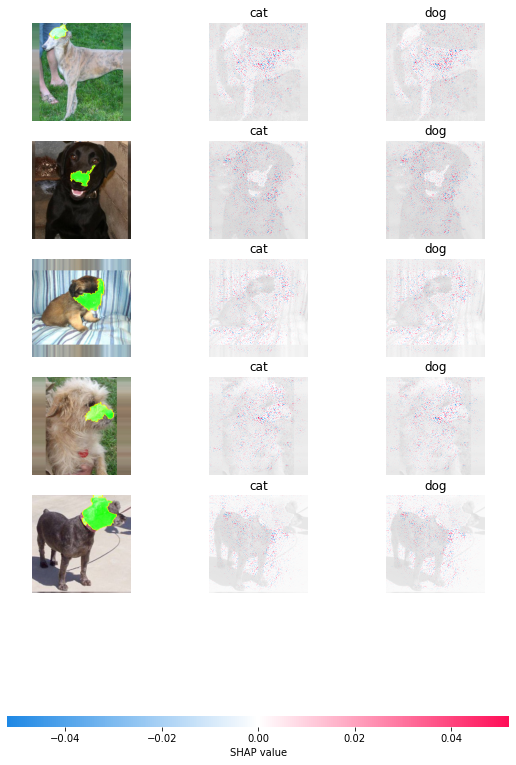

In [14]:
image_list = []
index_lab = []
index_pred = []
explain_list = []

for i in range(5):
  image, lab_name, pred_name = image_visable.get_image(idx_to_class[1], idx_to_class[1])

  exp = explain.lime_default(image, top_label=3)
  explain_list.append(explain.lime_explain(exp, 1))
  image_list.append(transfer(image))
  index_lab.append(lab_name)
  index_pred.append(pred_name)

explain_list = np.stack(explain_list)
image_list = torch.stack(image_list)
index_lab = np.array([np.array(class_names),np.array(class_names),np.array(class_names),np.array(class_names),np.array(class_names)])
index_pred = np.array(index_pred)


background = image_list.to(device)
e = shap.DeepExplainer(model, background)
n_test_images = 5
shap_values = e.shap_values(background)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]


shap.image_plot(shap_numpy, explain_list, index_lab)